In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from argparse import ArgumentParser
from sklearn.utils import shuffle
from skimage.io import imread
import PIL
import copy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as T
from torchvision import models

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar

import timm
import torchmetrics
import albumentations as albu
import albumentations.pytorch
import platform

# from torchsampler import ImbalancedDatasetSampler
# from torchmetrics.functional import auroc, precision, recall, f1_score, precision_recall_curve

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

if torch.cuda.is_available():
    print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    DEVICE = torch.device('cuda:0')
    accele = 'cuda'
else:
    print("\n[INFO] GPU not found. Using CPU: {}\n".format(platform.processor()))
    DEVICE = torch.device('cpu')
    accele = 'cpu'

Using device: cuda
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
[INFO] Using GPU: Tesla T4



In [3]:
data_dir = '/kaggle/input/full-fullsize/'

image_size = (224, 224)     # image input size (depends on data pre-processing)
val_percent = 0.1           # how much of total training samples are used for model selection (default 10%)
batch_size = 32             # batch size may need to be adjusted depending on GPU memory
epochs = 20                 # number of training epochs
num_workers = 3             # number threads for data processing

In [4]:
train_transform = albu.Compose([albu.Resize(image_size[0] + 30, image_size[0] + 30, p=1),
                                albu.RandomCrop(224, 224, p=1.0),
                                albu.Rotate(limit=10, p=0.8),
                                albu.HorizontalFlip(p=0.5),
                                albu.VerticalFlip(p=0.5),
                                albu.CoarseDropout(max_holes=8, min_holes=4,
                                                   max_height=10, max_width=10, 
                                                   p=0.5),
                                albu.Normalize(mean=0.0, std=1.0,
                                               max_pixel_value = 255),
                                albu.pytorch.ToTensorV2(),
                                ])
                                

test_transform = albu.Compose([albu.Resize(image_size[0], image_size[0], p=1),
                               albu.Normalize(mean=0.0, std=1.0,
                                              max_pixel_value = 255),
                               albu.pytorch.ToTensorV2(),
                               ])

In [5]:
class MammoDataset(Dataset):
    def __init__(self, data, data_dir, image_size, augmentation=None):
        self.data = data.reset_index(drop=True)
        self.data_dir = data_dir        
        self.image_size = image_size
        self.do_augment = augmentation

        self.samples = []
        for idx, _ in enumerate(tqdm(range(len(self.data)), desc='Loading Data')):
            img_path = os.path.join(self.data_dir, 'png/png', self.data.loc[idx, 'study_id'], self.data.loc[idx, 'image_id'] + '.png')
            img_label = np.array(self.data.loc[idx, 'malignancy_label'], dtype='int64')

            sample = {'image_path': img_path, 'label': img_label, 'study_id': self.data.loc[idx, 'study_id'], 'image_id': self.data.loc[idx, 'image_id']}
            self.samples.append(sample)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        sample = self.get_sample(item)

        image = sample['image']
        label = torch.from_numpy(sample['label'])         

        if self.do_augment is not None:
            transformed = self.do_augment(image=np.array(image.convert('RGB')))
            image = transformed["image"]      

        return {'image': image, 'label': label, 'study_id': sample['study_id'], 'image_id': sample['image_id']}

    def get_sample(self, item):
        sample = self.samples[item]
        image = PIL.Image.open(sample['image_path'])
#         image = imread().astype(np.float32)

        return {'image': image, 'label': sample['label'], 'study_id': sample['study_id'], 'image_id': sample['image_id']}
    
    def get_labels(self):
        labels = [int(sample['label']) for sample in self.samples]
        return labels

In [6]:
class MammoDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, image_size, val_percent, batch_size, num_workers):
        super().__init__()
        self.data_dir = data_dir
        self.image_size = image_size
        self.val_percent = val_percent
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.data = pd.read_csv(os.path.join(self.data_dir,'breast-level_annotations.csv'))
        self.data['malignancy_label'] = self.data['breast_birads']

        # Define positive and negatives based on BI-RADS categories
        self.data.loc[self.data['malignancy_label'] == 'BI-RADS 1', 'malignancy_label'] = 0
        self.data.loc[self.data['malignancy_label'] == 'BI-RADS 2', 'malignancy_label'] = 0
        self.data.loc[self.data['malignancy_label'] == 'BI-RADS 3', 'malignancy_label'] = 1
        self.data.loc[self.data['malignancy_label'] == 'BI-RADS 4', 'malignancy_label'] = 1
        self.data.loc[self.data['malignancy_label'] == 'BI-RADS 5', 'malignancy_label'] = 1

        # Use pre-defined splits to separate data into development and testing
        self.dev_data = self.data[self.data['split'] == 'training']
        self.test_data = self.data[self.data['split'] == 'test']

        # Split development data into training and validation (for model selection)
        # Making sure images from the same subject are within the same set
        unique_study_ids = self.dev_data.study_id.unique()

        unique_study_ids = shuffle(unique_study_ids)
        num_train = (round(len(unique_study_ids)*(1.0 - self.val_percent)))

        valid_sub_id = unique_study_ids[num_train:]
        self.dev_data.loc[self.dev_data.study_id.isin(valid_sub_id), "split"]="validation"
        
        self.train_data = self.dev_data[self.dev_data['split'] == 'training']
        self.val_data = self.dev_data[self.dev_data['split'] == 'validation']

        self.train_set = MammoDataset(self.train_data, data_dir, self.image_size, augmentation=train_transform)
        self.val_set = MammoDataset(self.val_data, data_dir, self.image_size, augmentation=test_transform)
        self.test_set = MammoDataset(self.test_data, data_dir, self.image_size, augmentation=test_transform)

        train_labels = self.train_set.get_labels()        
        train_class_count = np.array([len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)])

        val_labels = self.val_set.get_labels()        
        val_class_count = np.array([len(np.where(val_labels == t)[0]) for t in np.unique(val_labels)])

        test_labels = self.test_set.get_labels()        
        test_class_count = np.array([len(np.where(test_labels == t)[0]) for t in np.unique(test_labels)])

        print('samples (train): ',len(self.train_set))
        print('samples (val):   ',len(self.val_set))
        print('samples (test):  ',len(self.test_set))
        print('pos/neg (train): {}/{}'.format(train_class_count[1], train_class_count[0]))
        print('pos/neg (val):   {}/{}'.format(val_class_count[1], val_class_count[0]))
        print('pos/neg (test):  {}/{}'.format(test_class_count[1], test_class_count[0]))
        print('pos (train):     {:0.2f}%'.format(train_class_count[1]/len(train_labels)*100.0))
        print('pos (val):       {:0.2f}%'.format(val_class_count[1]/len(val_labels)*100.0))
        print('pos (test):      {:0.2f}%'.format(test_class_count[1]/len(test_labels)*100.0))

    def train_dataloader(self):
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

In [7]:
data = MammoDataModule(data_dir=data_dir,
                       image_size=image_size,
                       val_percent=val_percent,
                       batch_size=batch_size,
                       num_workers=num_workers)

Loading Data: 100%|██████████| 4000/4000 [00:00<00:00, 12408.83it/s]

samples (train):  14400
samples (val):    1600
samples (test):   4000
pos/neg (train): 1374/13026
pos/neg (val):   160/1440
pos/neg (test):  384/3616
pos (train):     9.54%
pos (val):       10.00%
pos (test):      9.60%


In [9]:
train_loader = data.train_dataloader()
train_load_visualize = next(iter(train_loader))
# Let's plot a batch of image
train_features, train_labels = train_load_visualize['image'], train_load_visualize['label']
print(train_features[0])
print(train_labels)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

tensor([[[0.5529, 0.5765, 0.5294,  ..., 0.0000, 0.0000, 0.0000],
         [0.6588, 0.5647, 0.6235,  ..., 0.0000, 0.0000, 0.0000],
         [0.6510, 0.6078, 0.5882,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.5059, 0.4784, 0.4863,  ..., 0.1294, 0.1294, 0.0863],
         [0.4745, 0.4510, 0.4471,  ..., 0.1451, 0.1373, 0.1255],
         [0.5255, 0.5412, 0.4902,  ..., 0.1255, 0.1412, 0.1451]],

        [[0.5529, 0.5765, 0.5294,  ..., 0.0000, 0.0000, 0.0000],
         [0.6588, 0.5647, 0.6235,  ..., 0.0000, 0.0000, 0.0000],
         [0.6510, 0.6078, 0.5882,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.5059, 0.4784, 0.4863,  ..., 0.1294, 0.1294, 0.0863],
         [0.4745, 0.4510, 0.4471,  ..., 0.1451, 0.1373, 0.1255],
         [0.5255, 0.5412, 0.4902,  ..., 0.1255, 0.1412, 0.1451]],

        [[0.5529, 0.5765, 0.5294,  ..., 0.0000, 0.0000, 0.0000],
         [0.6588, 0.5647, 0.6235,  ..., 0.0000, 0.0000, 0.0000],
         [0.6510, 0.6078, 0.5882,  ..., 0.0000, 0.0000, 0.

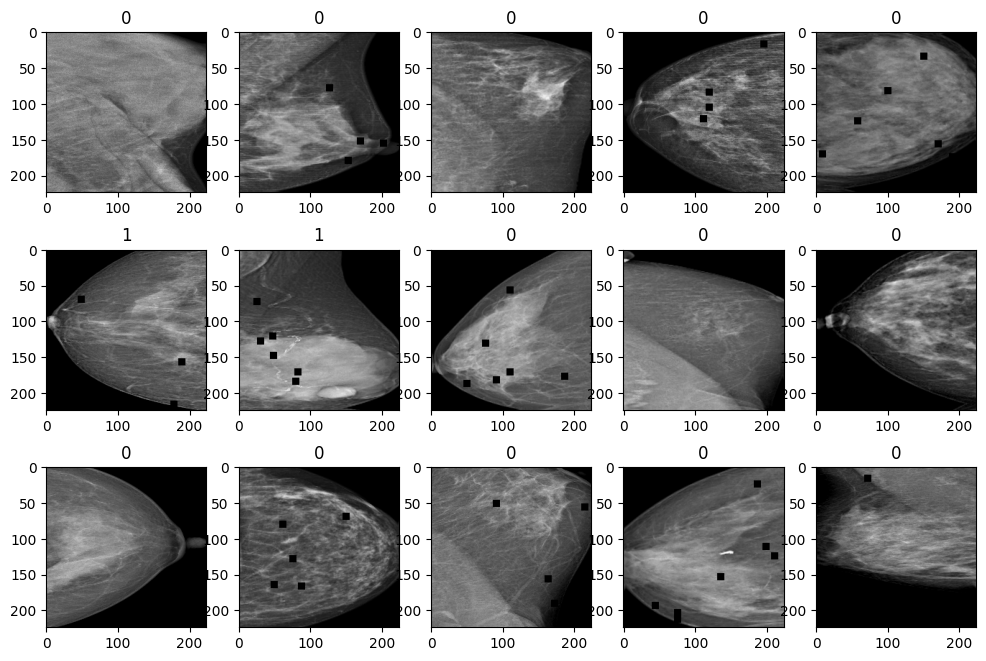

In [10]:
indx = 0
f, axarr = plt.subplots(3, 5, figsize=(12, 8))
for r in range(0, 3):
    for c in range(0, 5):
        img = train_features[indx].squeeze()
        label = train_labels[indx]
        axarr[r, c].imshow(torchvision.transforms.ToPILImage()(img))
        axarr[r, c].set_title(label.item())
        indx+=1

In [11]:
class MammoNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.num_classes = 2        
        self.predictions = []
        self.targets = []
        self.study_ids = []
        self.image_ids = []
        
        self.train_precision = torchmetrics.classification.Precision(num_classes=self.num_classes, average='macro', task='multiclass')
        self.train_recall = torchmetrics.classification.Recall(num_classes=self.num_classes, average='macro', task='multiclass')
        self.train_f1_score = torchmetrics.classification.F1Score(num_classes=self.num_classes, average='macro', task='multiclass')
        self.train_auc = torchmetrics.classification.AUROC(num_classes=self.num_classes, average='macro', task='multiclass')

        self.val_precision = torchmetrics.classification.Precision(num_classes=self.num_classes, average='macro', task='multiclass')
        self.val_recall = torchmetrics.classification.Recall(num_classes=self.num_classes, average='macro', task='multiclass')
        self.val_f1_score = torchmetrics.classification.F1Score(num_classes=self.num_classes, average='macro', task='multiclass')
        self.val_auc = torchmetrics.classification.AUROC(num_classes=self.num_classes, average='macro', task='multiclass')

        self.train_step_preds = []
        self.train_step_trgts = []
        self.val_step_preds = []
        self.val_step_trgts = []

        # Default model is an ImageNet pre-trained ResNet-18
        # self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.model = timm.create_model('tf_efficientnetv2_s.in21k_ft_in1k',
                                        pretrained=True,
                                       )
        
        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(num_features, self.num_classes)

    def forward(self, x):
        return self.model.forward(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def process_batch(self, batch):
        img, label = batch['image'], batch['label']
        out = self.forward(img)
        pred = torch.softmax(out, dim=1)
        criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.1, 1.0]).to(DEVICE))
        loss = criterion(out, label)        
        return loss, pred, label

    def training_step(self, batch, batch_idx):
        loss, pred, label = self.process_batch(batch)
        
        self.train_step_preds.append(pred)
        self.train_step_trgts.append(label)
        
        all_preds = torch.cat(self.train_step_preds, dim=0)
        all_trgts = torch.cat(self.train_step_trgts, dim=0)
        
        self.log('train_loss', loss, batch_size=batch_size, on_step=True, on_epoch=True, prog_bar=True)
        
        self.train_precision.update(all_preds, all_trgts)
        self.train_recall.update(all_preds, all_trgts)
        self.train_f1_score.update(all_preds, all_trgts)
        self.train_auc.update(all_preds, all_trgts)
        
        return loss

    def on_train_epoch_end(self):
        self.log('train_precision', self.train_precision.compute(), batch_size=batch_size, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_recall', self.train_recall.compute(), batch_size=batch_size, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_f1_score', self.train_f1_score.compute(), batch_size=batch_size, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_auc', self.train_auc.compute(), batch_size=batch_size, on_step=False, on_epoch=True, prog_bar=True)
        
        self.train_precision.reset()
        self.train_recall.reset()
        self.train_f1_score.reset()
        self.train_auc.reset()
        
        self.train_step_preds.clear()
        self.train_step_trgts.clear()

    def validation_step(self, batch, batch_idx):
        loss, pred, label = self.process_batch(batch)
        self.val_step_preds.append(pred)
        self.val_step_trgts.append(label)
        
        all_preds = torch.cat(self.val_step_preds, dim=0)
        all_trgts = torch.cat(self.val_step_trgts, dim=0)
        
        self.log('val_loss', loss, batch_size=batch_size, on_step=True, on_epoch=True, prog_bar=True)
        
        self.val_precision.update(all_preds, all_trgts)
        self.val_recall.update(all_preds, all_trgts)
        self.val_f1_score.update(all_preds, all_trgts)
        self.val_auc.update(all_preds, all_trgts)

    def on_validation_epoch_end(self):
        self.log('val_precision', self.val_precision.compute(), batch_size=batch_size, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_recall', self.val_recall.compute(), batch_size=batch_size, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1_score', self.val_f1_score.compute(), batch_size=batch_size, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_auc', self.val_auc.compute(), batch_size=batch_size, on_step=False, on_epoch=True, prog_bar=True)
        
        self.val_precision.reset()
        self.val_recall.reset()
        self.val_f1_score.reset()
        self.val_auc.reset()
        
        self.val_step_preds.clear()
        self.val_step_trgts.clear()

    def on_test_start(self):
        self.predictions = []
        self.targets = []
        self.study_ids = []
        self.image_ids = []

    def test_step(self, batch, batch_idx):
        _, pred, label = self.process_batch(batch)        
        self.predictions.append(pred)
        self.targets.append(label.squeeze())
        self.study_ids.append(batch['study_id'])
        self.image_ids.append(batch['image_id'])

In [12]:
def save_predictions(model, output_fname):
    prds = torch.cat(model.predictions, dim=0)
    trgs = torch.cat(model.targets, dim=0)
    std_ids = [id for sublist in model.study_ids for id in sublist]
    img_ids = [id for sublist in model.image_ids for id in sublist]
    cols_names = ['class_' + str(i) for i in range(0, 2)]

    df = pd.DataFrame(data=prds.cpu().numpy(), columns=cols_names)    
    df['target'] = trgs.cpu().numpy()
    df['study_id'] = std_ids
    df['image_id'] = img_ids
    df.to_csv(output_fname, index=False)
    
class MetricsCallback(pl.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_epoch_end(self, trainer, pl_module):
        each_me = copy.deepcopy(trainer.callback_metrics)
        self.metrics.append(each_me)

In [13]:
model = MammoNet()

# Create output directory
output_base_dir = '/kaggle/working/'
output_name = 'tf_efficientnetv2_s.in21k_ft_in1k'
output_dir = os.path.join(output_base_dir,output_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

In [ ]:
print('=============================================================')
print('Training...')

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode='min')
metric_cb = MetricsCallback()

trainer = pl.Trainer(callbacks=[checkpoint_callback, metric_cb,
                                RichProgressBar(leave=True)],
                     log_every_n_steps=2,
                     max_epochs=epochs,
                     accelerator=accele,
                     devices=1)
trainer.fit(model, data)

Training...


2024-04-06 03:12:50.618428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 03:12:50.618552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 03:12:50.787565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name            ┃ Type                ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ train_precision │ MulticlassPrecision │      0 │
│ 1 │ train_recall    │ MulticlassRecall    │      0 │
│ 2 │ train_f1_score  │ MulticlassF1Score   │      0 │
│ 3 │ train_auc       │ MulticlassAUROC     │      0 │
│ 4 │ val_precision   │ MulticlassPrecision │      0 │
│ 5 │ val_recall      │ MulticlassRecall    │      0 │
│ 6 │ val_f1_score    │ MulticlassF1Score   │      0 │
│ 7 │ val_auc         │ MulticlassAUROC     │      0 │
│ 8 │ model           │ EfficientNet        │ 20.2 M │
└───┴─────────────────┴─────────────────────┴────────┘

Trainable params: 20.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 20.2 M                                                                                               
Total estimated model params size (MB): 80

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [ ]:
# Access the logs 
# trainer.logged_metrics

In [18]:
metric_cb.metrics

[{'val_loss': tensor(0.7763, device='cuda:0'),
  'val_loss_epoch': tensor(0.7763, device='cuda:0')},
 {'train_loss': tensor(0.6049, device='cuda:0'),
  'train_loss_step': tensor(0.6049, device='cuda:0'),
  'val_loss': tensor(0.7980, device='cuda:0'),
  'val_loss_epoch': tensor(0.7980, device='cuda:0')},
 {'train_loss': tensor(0.7077, device='cuda:0'),
  'train_loss_step': tensor(0.7077, device='cuda:0'),
  'val_loss': tensor(0.6554, device='cuda:0'),
  'val_loss_epoch': tensor(0.6554, device='cuda:0'),
  'val_precision': tensor(0.5295, device='cuda:0'),
  'val_recall': tensor(0.5355, device='cuda:0'),
  'val_f1_score': tensor(0.1902, device='cuda:0'),
  'val_auc': tensor(0.7030, device='cuda:0'),
  'train_loss_epoch': tensor(0.6885, device='cuda:0'),
  'train_precision': tensor(0.5230, device='cuda:0'),
  'train_recall': tensor(0.5583, device='cuda:0'),
  'train_f1_score': tensor(0.4939, device='cuda:0'),
  'train_auc': tensor(0.5735, device='cuda:0')},
 {'train_loss': tensor(0.7144, d

In [19]:
model = MammoNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
print('=============================================================')
print('Testing...')

trainer.test(model=model, datamodule=data)
save_predictions(model=model, output_fname=os.path.join(output_dir, 'predictions.csv'))

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125/125 0:01:11 • 0:00:00 1.76it/s

In [20]:
pred_df = pd.read_csv(os.path.join(output_dir, 'predictions.csv'))
pred_df

,class_0,class_1,target,study_id,image_id
0,0.682221,0.317779,0,522963c771a84cb777c49ba7a4ca69fc,04c9b9305ae9a552975cceab2c15632e
1,0.780108,0.219892,0,522963c771a84cb777c49ba7a4ca69fc,a0b73dcf1c300988780abb9abe55826d
2,0.837972,0.162028,0,522963c771a84cb777c49ba7a4ca69fc,8132013f5158a2bc93d77ea9200c75d8
3,0.726920,0.273080,0,522963c771a84cb777c49ba7a4ca69fc,09c140f91b2da7c7ff024e5f4b2d5599
4,0.703104,0.296896,0,229b0c72152c8c7c6cd902876046c795,b045e8b4cbcacce80adb90ee8a9f885a
...,...,...,...,...,...
3995,0.603676,0.396324,0,5e9175554fa9d6b9fb424d7065be4f20,4adfc32f03228403f518f24e9b9313cf
3996,0.745251,0.254749,0,bbe97d67cc7f0d28bf9860a864af684a,4835a79d7e25eebd20104e7147cbcfb4
3997,0.700059,0.299941,0,bbe97d67cc7f0d28bf9860a864af684a,ebb437593a3fc80277296638f0607f5b
3998,0.790596,0.209404,0,bbe97d67cc7f0d28bf9860a864af684a,9188a01b6b648cee39fb70702a860141


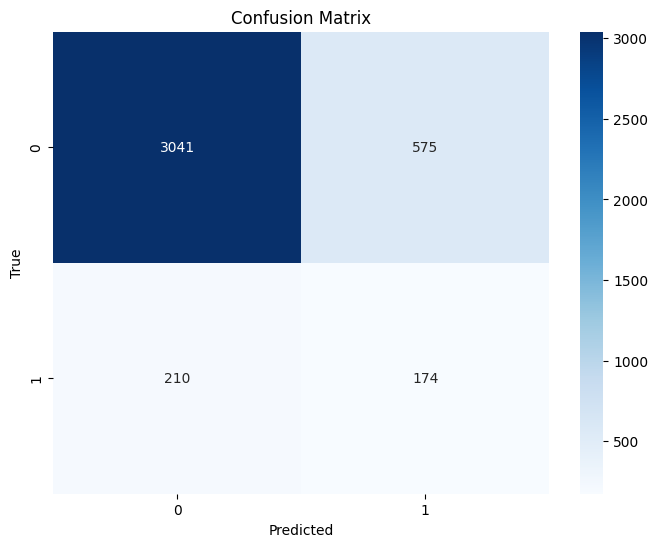

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      3616
           1       0.23      0.45      0.31       384

    accuracy                           0.80      4000
   macro avg       0.58      0.65      0.60      4000
weighted avg       0.87      0.80      0.83      4000



In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score

# Assuming df is your DataFrame containing probabilities and target
y_true = pred_df['target']
y_prob_class_1 = pred_df['class_1']

# Assuming class_1 is considered as positive class
y_pred = y_prob_class_1 >= 0.5  # Assuming threshold for class_1 is 0.5
# Convert to binary values
y_pred_binary = y_pred.astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, normalize=None)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, fmt="d", annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate classification report
report = classification_report(y_true, y_pred_binary)
print(report)

In [22]:
# Calculating precision, recall, and F1 score
test_precision = precision_score(y_true, y_pred, average='macro')
test_recall = recall_score(y_true, y_pred, average='macro')
test_f1 = f1_score(y_true, y_pred, average='macro')

# Calculating AUC score
test_auc = roc_auc_score(y_true, y_prob_class_1)

print('Precison:', test_precision)
print('Recall:', test_recall)
print('F1 Score:', test_f1)
print('AUC:', test_auc)

Precison: 0.5838571186271535
Recall: 0.6470547566371682
F1 Score: 0.5964171612163062
AUC: 0.7172433858775812
